# Laden der Daten und Inspizieren der Daten (kopiert)

In [1]:
notebook_title = "unet_data_augmented_dropout"

In [2]:
%run ./utils/load_data.ipynb

/home/aie3/albert/flood-area-segmentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No of images:  290
No of masks:  290
(290, 224, 224, 3)
Loaded 290 images and masks.


# Data augmentation


In [3]:
# import import_ipynb
# from utils.data_augmentation import augment

# augmented_images, augmented_masks = augment(images, masks)

%run ./utils/data_augmentation.ipynb

print("Dataset size before augmentation: ", images.shape[0])
print("Dataset size after augmentation:", augmented_images.shape[0])

Dataset size before augmentation:  290
Dataset size after augmentation: 2610


### Auteilung in Train und Validation Daten
- 70% Training
- 15% Validierung
- 15% Test

In [4]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (1827, 224, 224, 3)
Val:   (391, 224, 224, 3)
Test:  (392, 224, 224, 3)


#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

In [5]:
# limit the usage of GPU memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-06-18 00:15:38.678827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750205738.697675 3612118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750205738.703520 3612118 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750205738.718025 3612118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750205738.718046 3612118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750205738.718048 3612118 computation_placer.cc:177] computation placer alr

# Model

In [6]:
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

from utils.u_net_v2_dropout import unet_model

model = unet_model((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])
model.summary()

I0000 00:00:1750205746.597678 3612118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76039 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1750205746.599119 3612118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79183 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1750205746.602025 3612118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79183 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:a1:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 28, 28,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ dropout_3[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
BATCH_SIZE = 32

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50


I0000 00:00:1750205762.471411 3613837 service.cc:152] XLA service 0x7fd3c0109fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750205762.471507 3613837 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1750205762.471515 3613837 service.cc:160]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1750205762.471527 3613837 service.cc:160]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-06-18 00:16:02.639029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750205763.246698 3613837 cuda_dnn.cc:529] Loaded cuDNN version 91001


 3/58 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4331 - f1_metric: 0.5035 - iou_metric: 0.3415 - loss: 0.6954 - precision_metric: 0.4009 - recall_metric: 0.7677  

I0000 00:00:1750205777.567264 3613837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.5954 - f1_metric: 0.3426 - iou_metric: 0.2348 - loss: 0.6376 - precision_metric: 0.5386 - recall_metric: 0.3372 - val_accuracy: 0.7501 - val_f1_metric: 0.6626 - val_iou_metric: 0.4972 - val_loss: 0.4975 - val_precision_metric: 0.8396 - val_recall_metric: 0.5506
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7585 - f1_metric: 0.7136 - iou_metric: 0.5576 - loss: 0.4814 - precision_metric: 0.7667 - recall_metric: 0.6900 - val_accuracy: 0.7826 - val_f1_metric: 0.7606 - val_iou_metric: 0.6145 - val_loss: 0.4222 - val_precision_metric: 0.7678 - val_recall_metric: 0.7555
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7845 - f1_metric: 0.7513 - iou_metric: 0.6046 - loss: 0.4319 - precision_metric: 0.8026 - recall_metric: 0.7156 - val_accuracy: 0.8056 - val_f1_metric: 0.7969 - val_iou_metric: 0.6630 - val_loss: 0.4029 - val_precision_metric: 0.7758 - val_recall_metric: 0.8209
Epoch 4/50
58/58 ━━━━━━━━━━━

Die Werte der Metrik "Intersection over Union (IoU)" hat sich eigentlich nicht verbessert auf dem Validation Set. Es war schon besser ohne Dropout.

# Nach 50 Epochen

## 2025-06-17
accuracy: 0.8986 - f1_metric: 0.9063 - iou_metric: 0.8288 - loss: 0.1832 - precision_metric: 0.9223 - recall_metric: 0.8913 - val_accuracy: 0.8892 - val_f1_metric: 0.8932 - val_iou_metric: 0.8072 - val_loss: 0.2258 - val_precision_metric: 0.8967 - val_recall_metric: 0.8900

## 2025-06-17
accuracy: 0.8991 - f1_metric: 0.9085 - iou_metric: 0.8326 - loss: 0.1814 - precision_metric: 0.9202 - recall_metric: 0.8974 - val_accuracy: 0.8865 - val_f1_metric: 0.8855 - val_iou_metric: 0.7948 - val_loss: 0.2218 - val_precision_metric: 0.9308 - val_recall_metric: 0.8449

## 2025-06-17
accuracy: 0.8971 - f1_metric: 0.9068 - iou_metric: 0.8298 - loss: 0.1843 - precision_metric: 0.9213 - recall_metric: 0.8933 - val_accuracy: 0.8917 - val_f1_metric: 0.8980 - val_iou_metric: 0.8150 - val_loss: 0.2122 - val_precision_metric: 0.9034 - val_recall_metric: 0.8929

## Model speichern

In [8]:
model.save(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

# accuracy: 0.8877 - f1_metric: 0.8970 - iou_metric: 0.8136 - loss: 0.2136 - precision_metric: 0.9172 - recall_metric: 0.8783 - val_accuracy: 0.8671 - val_f1_metric: 0.8674 - val_iou_metric: 0.7664 - val_loss: 0.2580 - val_precision_metric: 0.8898 - val_recall_metric: 0.8463

# Diagramme

In [9]:
print(history.history.keys())

dict_keys(['accuracy', 'f1_metric', 'iou_metric', 'loss', 'precision_metric', 'recall_metric', 'val_accuracy', 'val_f1_metric', 'val_iou_metric', 'val_loss', 'val_precision_metric', 'val_recall_metric'])


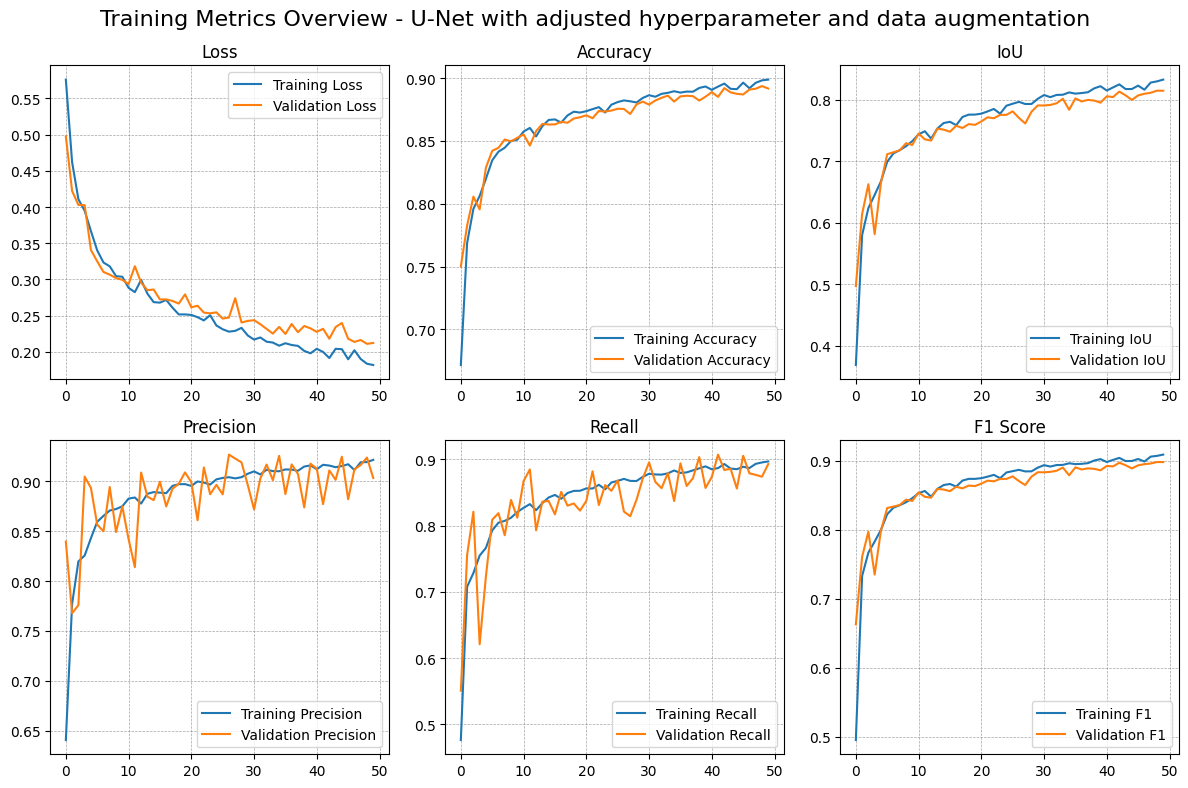

In [10]:
# Plot training history
from datetime import datetime
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color


plt.suptitle('Training Metrics Overview - U-Net with adjusted hyperparameter and data augmentation', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was die Diagramme zeigen:

Es ist zu sehen, dass wir mit dem Dropout das Overfitting des Models bewältigt haben.

### Modell evaluieren mit Testdaten

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step

===== Final Test Evaluation =====
Precision: 0.9019
Recall:    0.8933
F1 Score:  0.8976
IoU:       0.8141



## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.9033
Recall:    0.8891
F1 Score:  0.8961
IoU:       0.8118

## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.9344
Recall:    0.8439
F1 Score:  0.8868
IoU:       0.7967

## 2025.06.17
===== Final Test Evaluation =====
Precision: 0.9019
Recall:    0.8933
F1 Score:  0.8976
IoU:       0.8141


#### Vergleich der Metriken für Train, Validation und Test

In [12]:
import import_ipynb
from utils.metrics_barplot import metrics_summary

metrics_summary_results = metrics_summary(history, y_true_flat, y_pred_flat, precision, recall, f1, iou)

print("\n===== Training, Validation und Test Metriken =====")
print(metrics_summary_results.to_string(index=False, float_format="%.4f"))


===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8988     0.9215  0.8968    0.9088 0.8331
  Val    0.8917     0.9034  0.8929    0.8980 0.8150
 Test    0.9199     0.9019  0.8933    0.8976 0.8141



## 2025.06.17
===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8959     0.9195  0.8915    0.9051 0.8269
  Val    0.8892     0.8967  0.8900    0.8932 0.8072
 Test    0.9190     0.9033  0.8891    0.8961 0.8118

## 2025.06.17
 ===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8960     0.9191  0.8937    0.9059 0.8282
  Val    0.8865     0.9308  0.8449    0.8855 0.7948
 Test    0.9154     0.9344  0.8439    0.8868 0.7967

## 2025.06.17
 ===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.8988     0.9215  0.8968    0.9088 0.8331
  Val    0.8917     0.9034  0.8929    0.8980 0.8150
 Test    0.9199     0.9019  0.8933    0.8976 0.8141

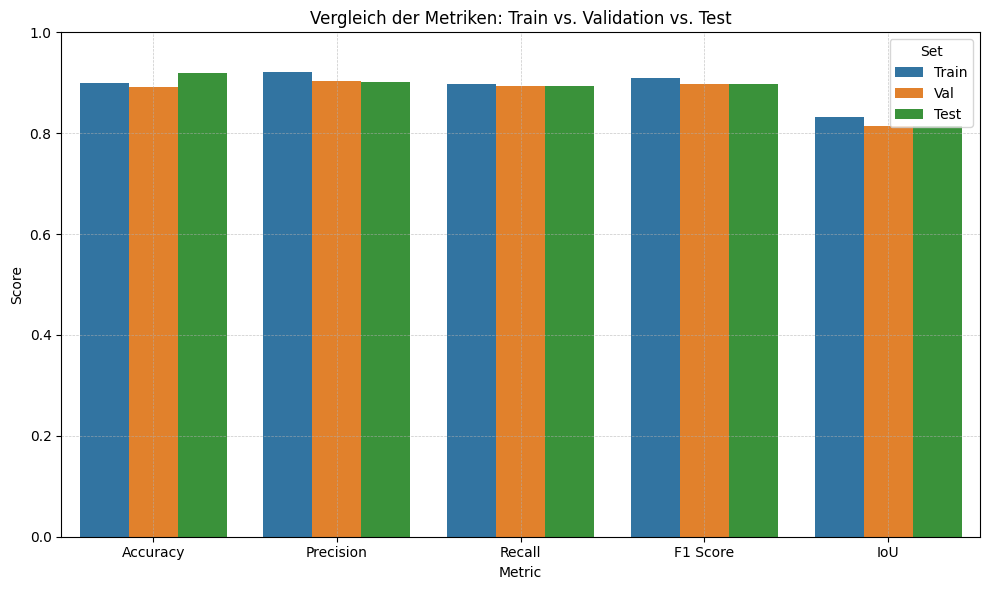

In [13]:
import import_ipynb
from utils.metrics_barplot import draw_metrics_barplot

draw_metrics_barplot(metrics_summary_results, save_title=f"{notebook_title}_batch_size_{BATCH_SIZE}")

Es gibt kein Overfitting mehr!

# Visualize predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


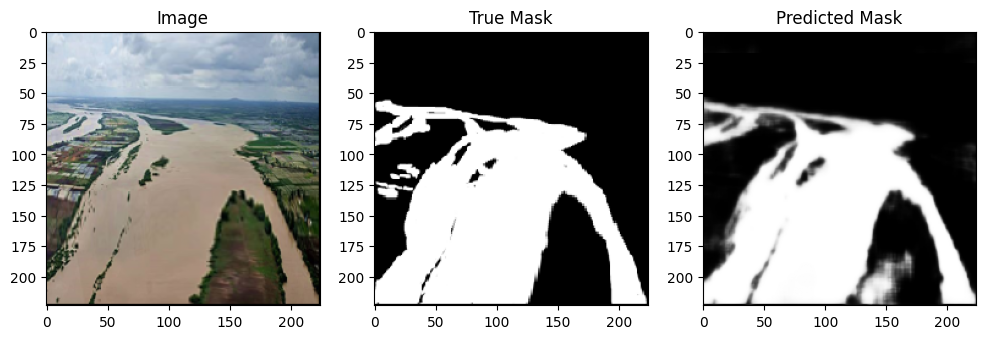

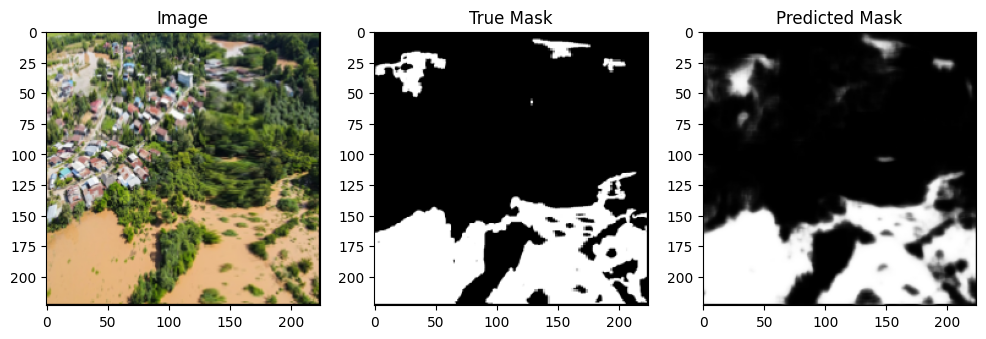

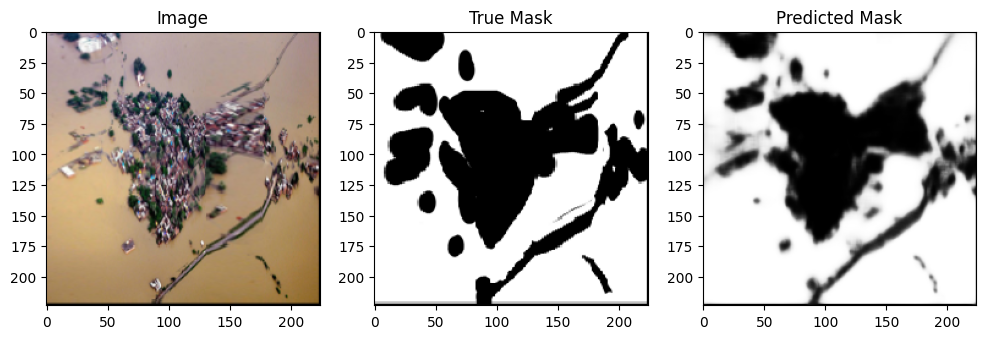

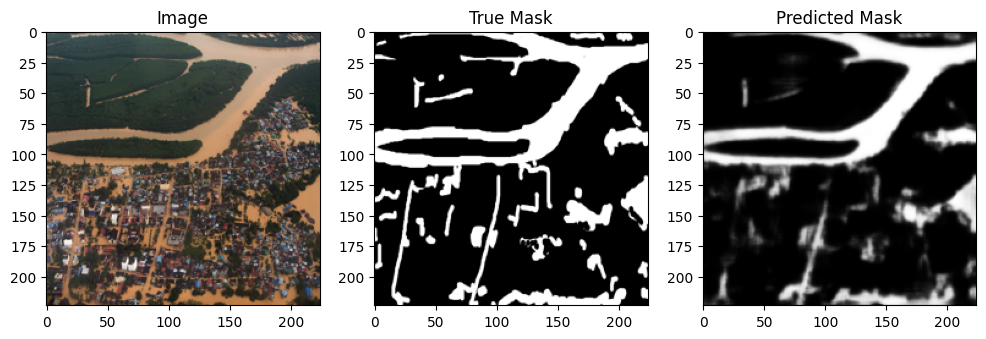

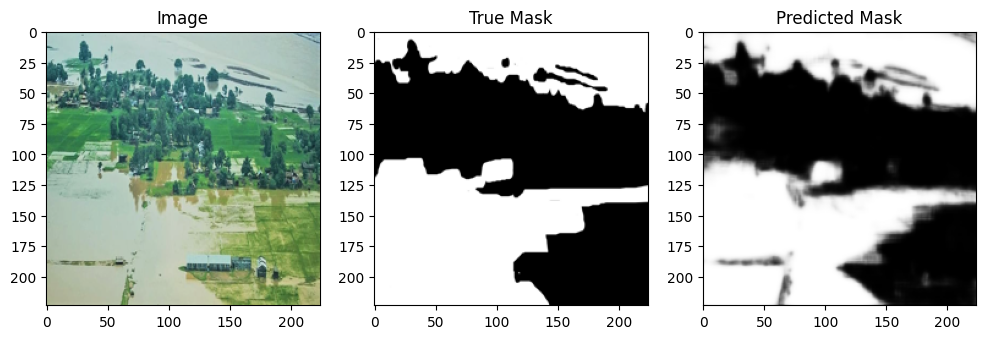

In [14]:
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import load_model

# Imports relevant for loading the model
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

def visualize_predictions(num_images=5):
    preds = model.predict(X_test[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_test[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_test[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')


        plt.savefig(f'./img/visualized_predictions/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
        plt.show()

visualize_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


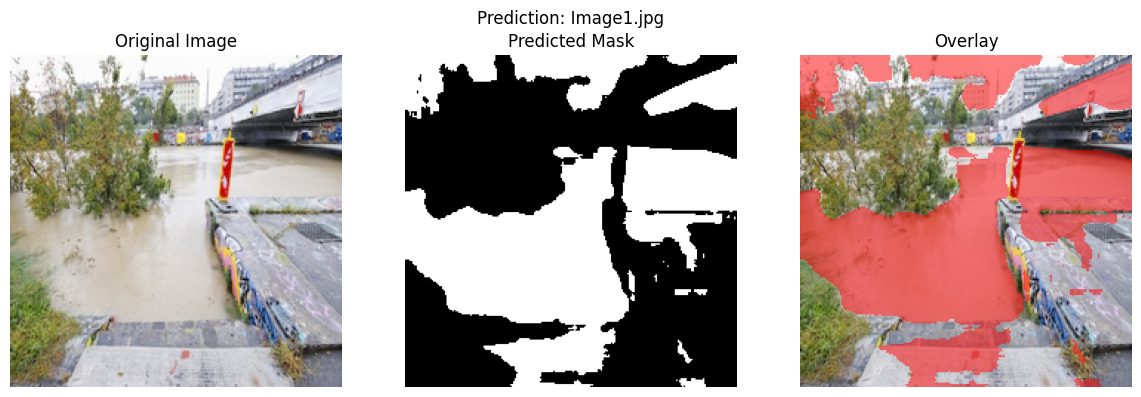

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


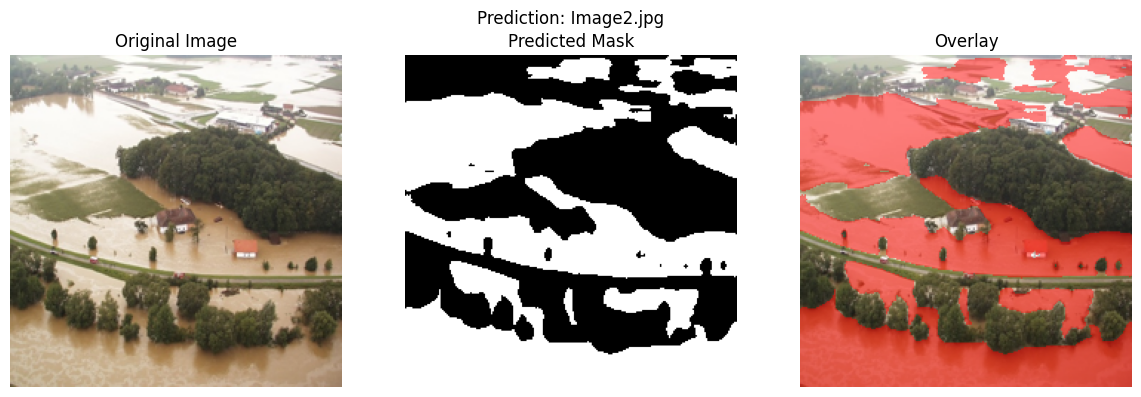

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


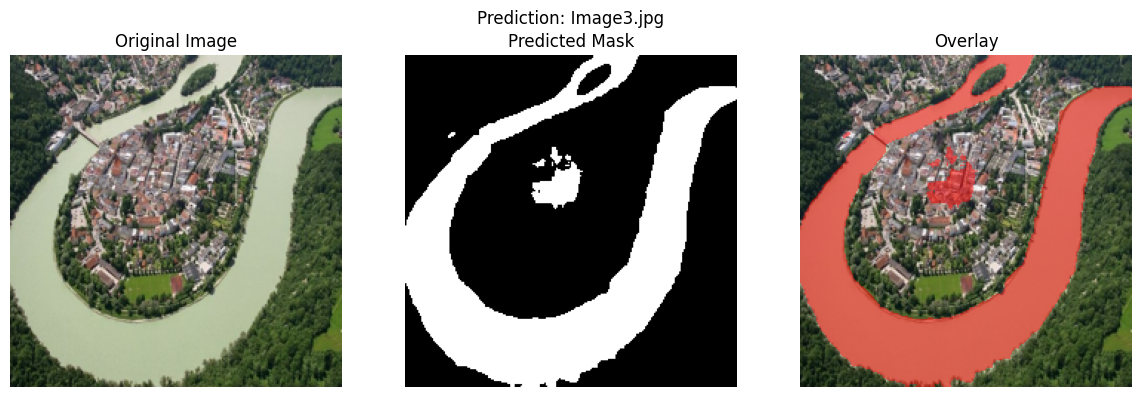

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


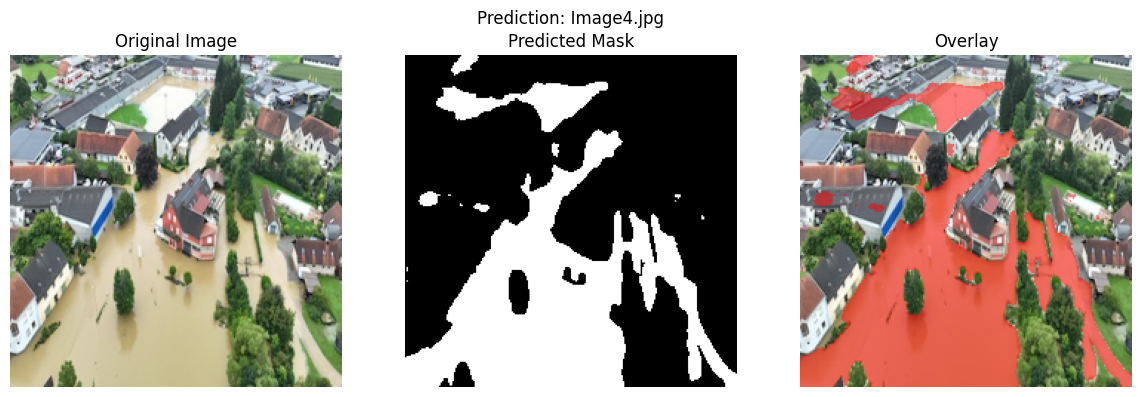

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


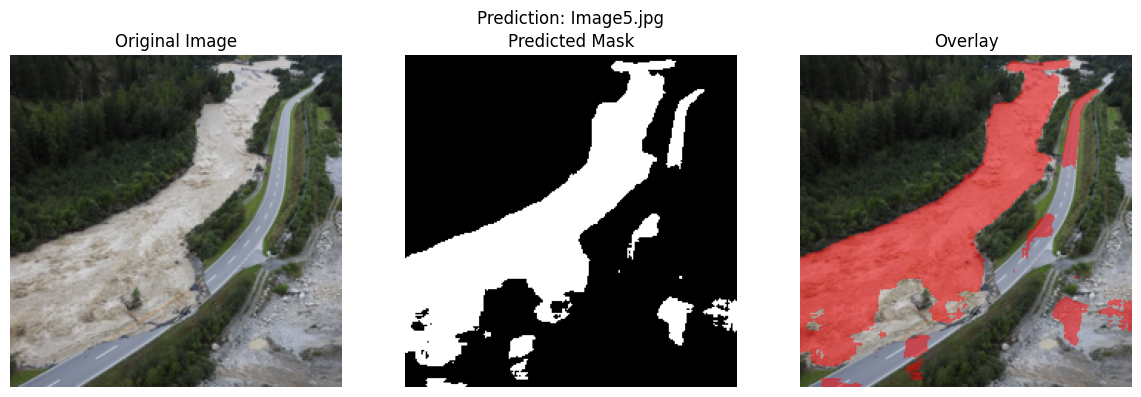

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


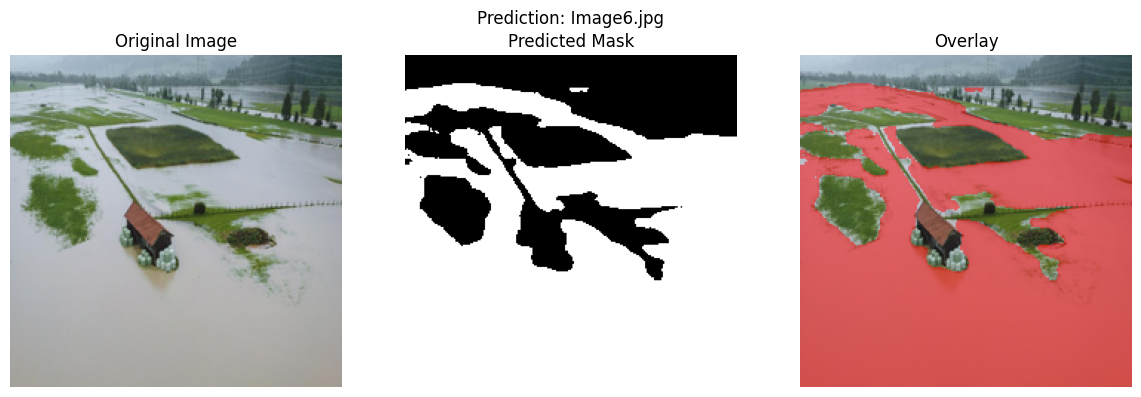

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


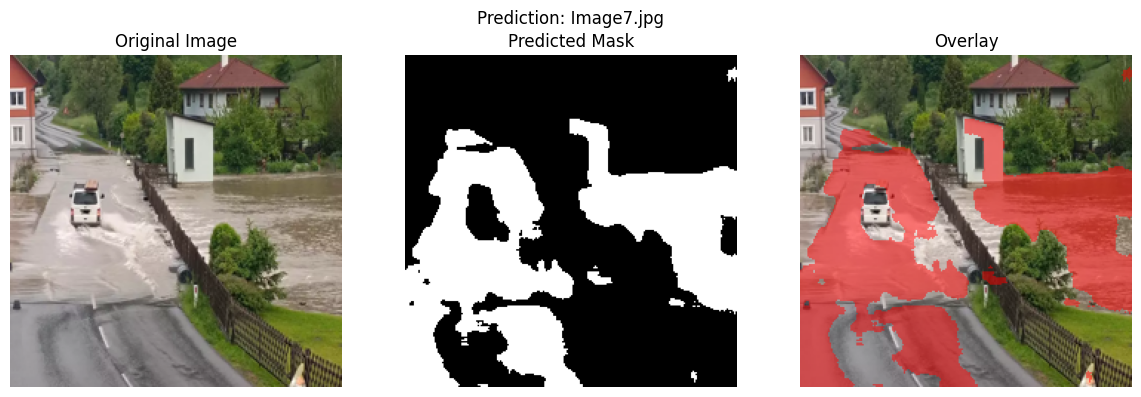

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


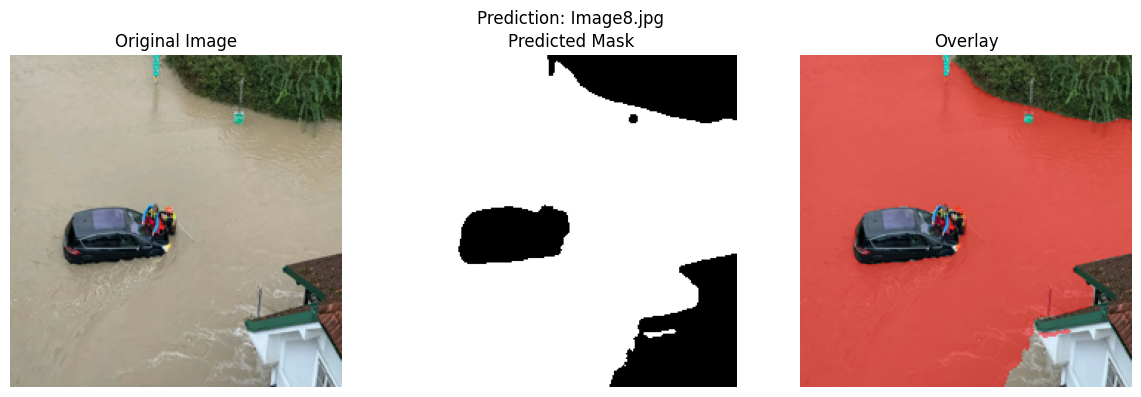

In [15]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
        image_resized=np.array(image_resized), 
        pred_binary=pred_binary, 
        img_file=img_file,
        alpha=ALPHA,
        is_saved=True,
        save_title=f"adjusted_hyperparameter_batch_size_64"
    )